# Patch analysis

An aerial image of the Marion County Lake and Park (Lat: 38.320885, Lon: -96.983912) near Marion, KS was labeled into its major landscape components using a labeling tool. The labeling basically consisted of painting by hand using a brush or flooding tool different features of the landscape such as the lake itself, impervious road delimiting the boundary of the park, pervious roads within the park area, fishing docks, and buildings (mobile homes, shelters).

Marion County Lake and Park is primarily used for recreational activitis such as fishing, boating, jogging, and even bird watching. There is a residential area right outside the edge of the park that was not included in this analysis since we are only concerned with the land ara of the park. 

The goal is to quantify the size and shape properties of the different land patches within the land area of the park that are isolated due to roads. Hopefully you can see from the aerial image that within the park there multiple road loops covered with gravel. While these internal roads were developed to facilitate access to fishing docks and picnic areas, there seems to be substantial fragmentation of the land area.

We will use some image analysis tools to quantify the total lake and park area, the lake area, the land area, the surface covered by roads, the number of fishing docks, and the classification, numer, and size of patches.


Each label is repreented in the image with a specific number assigned during the labelling process:

## Labels

`0` = background

`1` = pervious roads

`2` = impervious roads

`3` = water body (lake area)

`4` = fishing and boating docks

`5` = Buildings and houses


## Image source and resolution

The aerial image was exported from Google Earth Pro. The image is not georeferenced, but the size of an individual pixel is approximately 0.75 squared meters

In [1]:
# Import modules
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from skimage import io
from scipy import ndimage


In [1]:
import ee

ModuleNotFoundError: No module named 'gee'

The first step before we do any data analysisis is to import the aerial and labeled images. The rea re multiple alternatives to do this. We can use methods within the scikit-image library, methods within the `matplotlib` library or we can even consider installing other modules such as `OpenCV`.

We will use the imread method available in scikit-image for consistency with the rest of the operations along the exercise.

In [3]:
# Read aerial image
image_aerial = io.imread("../datasets/marion_park/marion_county_lake_park_aerial.jpg")

# Read labeled image
image_labels = io.imread("../datasets/marion_park/marion_county_lake_park_labels.png")

Most images have two dimensions (grayscale) or three dimension (red, green, and blue). It is always good to quickly check the dimensions of the image.

In [4]:
# Print image shape
image_labels.shape

(2886, 4800)

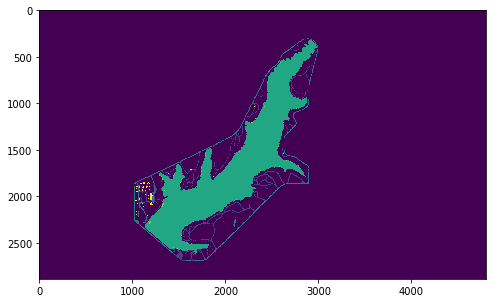

In [5]:
plt.figure(figsize=(8,6))
plt.imshow(image_labels)
plt.show()

In [6]:
# Extract features in separate variables
background = image_labels == 0
pervious_roads = image_labels == 1
impervious_roads = image_labels == 2
lake = image_labels == 3
docks = image_labels == 4
buildings = image_labels == 5


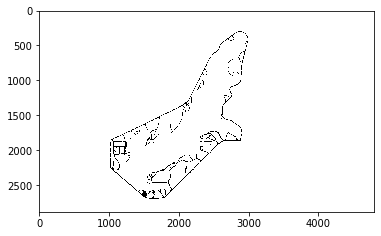

In [7]:
all_roads = pervious_roads | impervious_roads
plt.imshow(all_roads, cmap=cm.binary)
plt.show()


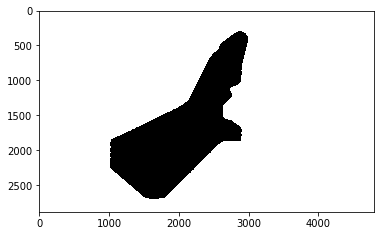

In [39]:
# Compute park
lake_and_park = ndimage.binary_fill_holes(all_roads)
plt.imshow(lake_and_park, cmap=cm.binary)
plt.show()

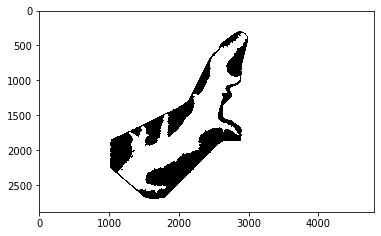

In [40]:
# Compute land
park = lake_and_park & ~lake
plt.imshow(park, cmap=cm.binary)
plt.show()

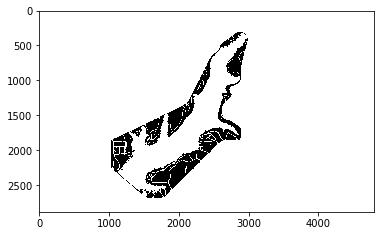

In [41]:
park_patches = park & ~all_roads
plt.imshow(park_patches, cmap=cm.binary)
plt.show()

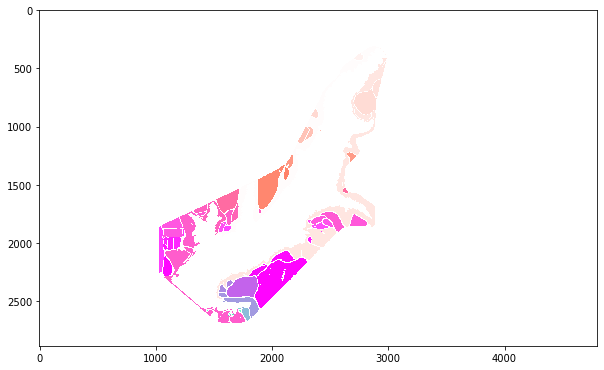

In [85]:
from skimage.color import label2rgb
labeled_patches,_ = ndimage.label(park_patches)


# Custom colormap
from matplotlib.colors import LinearSegmentedColormap
colors = [(1, 1, 1), (1, 0.5, 0.4), (1, 0.3, 1), (1, 0, 1), (0.4,1,0.8), (0.3,0.7,0.7)] 
cm = LinearSegmentedColormap.from_list('lake_patches', colors)


plt.figure(figsize=(10,8))
plt.imshow(labeled_patches, cmap=cm)
plt.show()

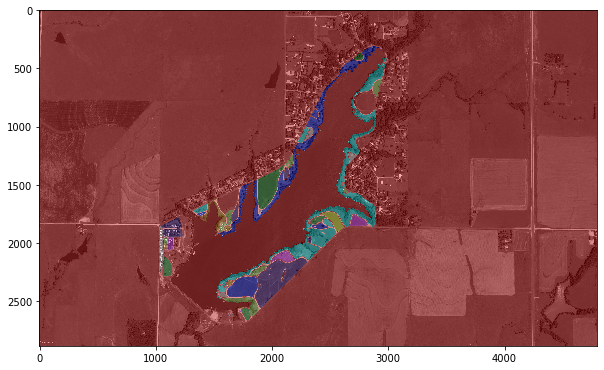

In [13]:
patches_overlay = label2rgb(labeled_patches, image=image_aerial)

plt.figure(figsize=(10,8))
plt.imshow(patches_overlay)
plt.show()

In [16]:
from skimage.measure import regionprops_table
props = regionprops_table(labeled_patches, properties=('centroid',
                                                        'area',
                                                        'major_axis_length',
                                                        'minor_axis_length'))

In [19]:
import pandas as pd
props = pd.DataFrame(props)
props.head()

centroid-0  centroid-1    area  major_axis_length  minor_axis_length
0        1189        2217  118295        2314.431978         295.586768
1         322        2926       1           0.000000           0.000000
2         353        2959     287          80.236387           7.807229
3         405        2754    2992          77.429743          52.171199
4         390        2982       1           0.000000           0.000000

In [21]:
# Convert area from number of pixels to m^2
props["area"] = props["area"] * 0.75 # 1 pixels is about 0.75 m^2

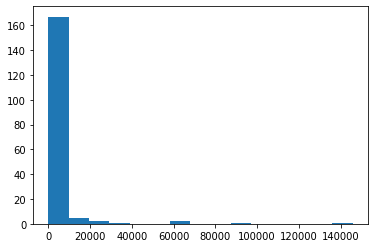

In [86]:
plt.hist(props.area, bins=15)
plt.show()